# Herron Topic 3 - Practice for Section 03

## Announcements

1. We will make a few changes to give us more time to work on Project 3:
    1. We will drop Herron Topic 5 on simulations during Week 14 and use this time for group work
    2. I will finalize Project 3 by Thursday, 4/4, so we have about 3 week to work on it before the Tuesday, 4/23, due date
2. ***Next Thursday and Friday, 4/11 and 4/12, we will take the MSFQ assessment exam in class. I do not control this exam, and there are a few conditions:***
    1. ***Open book***
    2. ***On Canvas***
    3. ***In the classroom***

## 10-Minute Recap

1. The Capital Asset Pricing Model (CAPM) estimates asset $i$'s expected return as $E(r_i) = r_f + \beta_i [E(r_M) - r_f]$, where:
    1. $r_f$ is the risk-free rate 
    2. $\beta_i$ is asset $i$'s systematic risk 
    3. $E(r_M) - r_f$ is the market risk premium 
2. The Security Market Line (SML) visualizes the CAPM
    1. Plots $E(r_i)$ on the y axis against $\beta_i$ on the x axis
    2. The slope of the SML is the market risk premium $E(r_M) - r_f$
    3. The intercept of the SML is the risk-free rate $r_f$
3. We can estimate asset $i$'s systematic risk a few ways:
    1. $\beta_i = \frac{Cov(r_i-r_f, r_M-r_f)}{Var(r_M-r_f)}$
    2. $\beta_i = Corr(r_i-r_f, r_M-r_f) \frac{Std(r_i-r_f)}{Std(r_M-r_f)}$
    3. Estimate the linear regression $r_i - r_f = \alpha_i + \beta_i [r_M - r_f] + \varepsilon_i$ with the `smf.ols()` function after we `import statsmodels.formula.api as smf`
    4. We will follow Bodie, Kane, and Marcus's syntax where a $r$ is a raw return and a $R$ is an excess return, so $R_i = r_i - r_f$
4. The CAPM is the foundation of modern finance and does well for single periods but has a few shortcomings:
    1. Does poorly over multiple periods
    2. The SML is "too flat" empirically, and high $\beta$ assets tend to have lower returns than expected
    3. Does explain the returns on several factors, like size, value, and momentum
4. The Fama-French 3-factor model---and many others---attempts to solves these shortcomings and is useful for evaluating fund manager performance 

##  Practice

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import seaborn as sns
import statsmodels.formula.api as smf
import yfinance as yf

In [2]:
%precision 4
pd.options.display.float_format = '{:.4f}'.format
%config InlineBackend.figure_format = 'retina'

### Plot the security market line (SML) for a variety of asset classes

Use the past three years of daily data for the following exhange traded funds (ETFs):

1. SPY (SPDR---Standard and Poor's Depository Receipts---ETF for the S&P 500 index)
1. BIL (SPDR ETF for 1-3 month Treasury bills)
1. GLD (SPDR ETF for gold)
1. JNK (SPDR ETF for high-yield debt)
1. MDY (SPDR ETF for S&P 400 mid-cap index)
1. SLY (SPDR ETF for S&P 600 small-cap index)
1. SPBO (SPDR ETF for corporate bonds)
1. SPMB (SPDR ETF for mortgage-backed securities)
1. SPTL (SPDR ETF for long-term Treasury bonds)

In [3]:
tickers = 'SPY BIL GLD JNK MDY SLY SPBO SPMB SPTL'

For multifactor models, we generally leave returns in percents.
Slope coefficient estimates (i.e., $\beta$s) are the same for decimal and percent returns.
Intercept coefficient estimates (i.e., $\alpha$s) are easier to interpret in percents than in decimals because small percent returns have two fewer zeros than small decimal returns.

In [4]:
etf = (
    yf.download(tickers=tickers)
    ['Adj Close']
    .iloc[:-1]
    .pct_change()
    .mul(100)
)

etf.head()

[*********************100%%**********************]  9 of 9 completed
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2517263847.py:5: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


,BIL,GLD,JNK,MDY,SLY,SPBO,SPMB,SPTL,SPY
Date,,,,,,,,,
1993-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1993-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.7112
1993-02-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.2119
1993-02-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0571
1993-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4184


In [5]:
ff = (
    pdr.DataReader(
        name='F-F_Research_Data_Factors_daily',
        data_source='famafrench',
        start='1900'
    )
    [0]
)

ff.tail()

C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\3487692931.py:2: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


,Mkt-RF,SMB,HML,RF
Date,,,,
2024-02-23,0.0200,0.2800,-0.0300,0.0210
2024-02-26,-0.2600,1.0000,-0.1100,0.0210
2024-02-27,0.2700,1.1900,-0.4500,0.0210
2024-02-28,-0.2600,-0.8500,0.0000,0.0210
2024-02-29,0.5400,-0.3400,0.9800,0.0210


We will write two helper functions to make it easier to calculate annualized mean returns and CAPM betas.
We will pass these function names to the pandas `.agg()` method, which applies these functions to every column and combines the results.

In [6]:
def calc_ann_mean(ri, ann_fac=252):
    return ri.mean() * ann_fac

In [7]:
etf.apply(calc_ann_mean)

BIL     0.9715
GLD     9.6202
JNK     5.2090
MDY    12.9373
SLY     9.4062
SPBO    3.3207
SPMB    2.1316
SPTL    4.4217
SPY    11.4856
dtype: float64

In [8]:
def calc_beta(ri, rf=ff['RF'], RM=ff['Mkt-RF']):
    # betai = Cov(Ri, RM) / Var(RM)
    Ri = ri.sub(rf).dropna() # Ri is excess returns for asset i
    return Ri.cov(RM) / RM.loc[Ri.index].var() # we use .loc[] to slice RM to the same dates as Ri

In [9]:
etf.apply(calc_beta)

BIL    -0.0030
GLD     0.0475
JNK     0.3547
MDY     1.0540
SLY     1.0626
SPBO    0.0468
SPMB    0.0522
SPTL   -0.2212
SPY     0.9819
dtype: float64

We should estimate CAPM betas from one-year to three-years of daily returns.

In [10]:
etf_sml = (
    etf
    .loc['2021-02':'2024-01']
    .agg([calc_ann_mean, calc_beta])
    .transpose()
)

The `regplot()` function in the seaborn package plots a scatterplot and adds a best-fit line with 95% confidence interval.

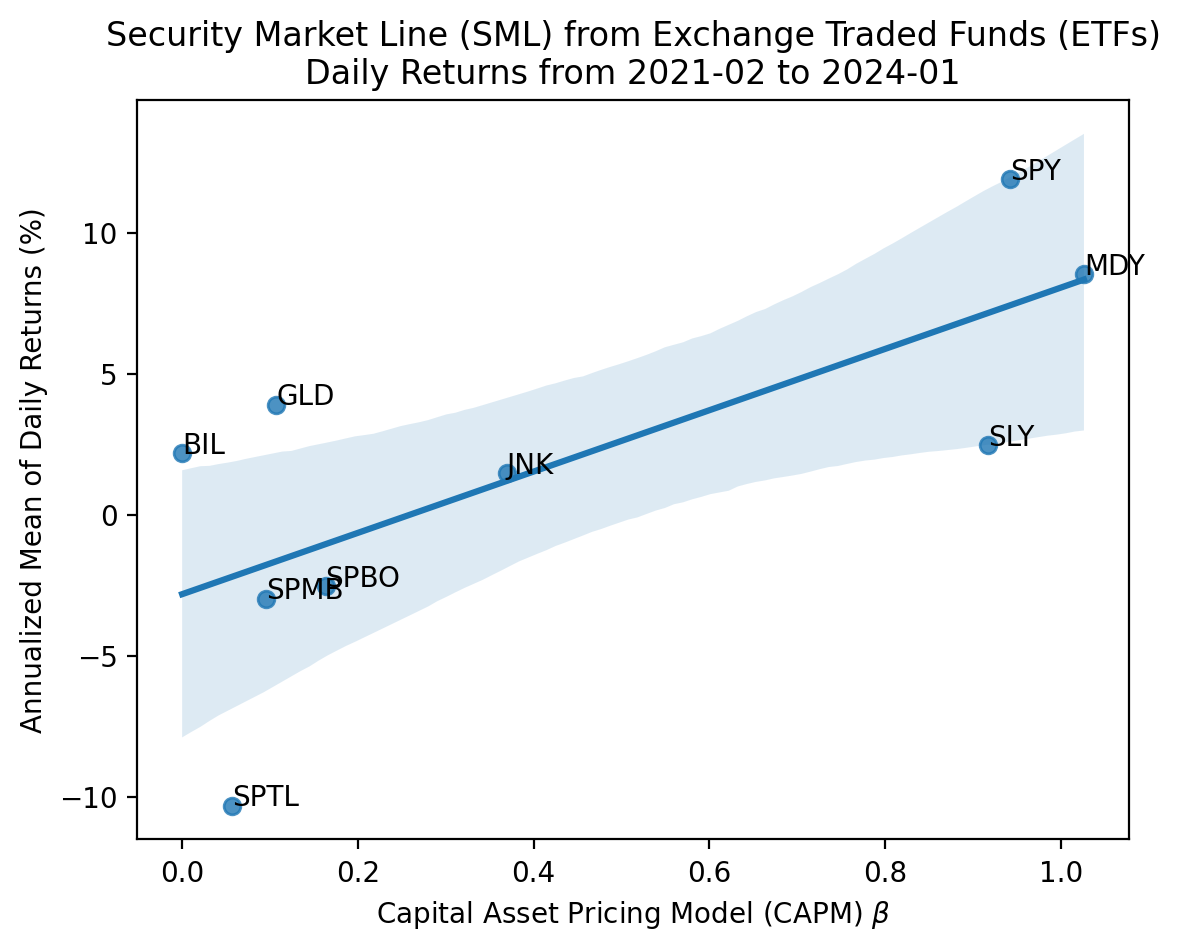

In [11]:
sns.regplot(
    data=etf_sml,
    x='calc_beta',
    y='calc_ann_mean'
)

for t, (x, y) in etf_sml[['calc_beta', 'calc_ann_mean']].iterrows():
    plt.annotate(text=t, xy=(x, y))


plt.ylabel('Annualized Mean of Daily Returns (%)')
plt.xlabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
plt.title(
    'Security Market Line (SML) from Exchange Traded Funds (ETFs)\n' +
    'Daily Returns from 2021-02 to 2024-01'
)
plt.show()

***We see the CAPM and SML work well for asset classes!***
The slope is positive, the intercept is a reasonable risk-free rate, and assets plot along the SML, most within the 95% confidence interval.
Note that a few fixed-income ETFs have negative mean returns, but the SML still has the shape and fit we expect by theory.

The fit above is not perfect, but the $R^2$ is fairly high at around 50%.
For a single-factor regression, we can quickly calculate $R^2$ as $\rho^2$.

In [12]:
etf_sml.corr().loc['calc_ann_mean', 'calc_beta']**2

0.5086

In [13]:
smf.ols(formula='calc_ann_mean ~ calc_beta', data=etf_sml).fit().rsquared

0.5086

---

The `.iterrows()` method helps us loop over the rows in a data frame without creating a loop counter.
Here is an example, similar to our use above.

In [14]:
for t, (x, y) in etf_sml[['calc_beta', 'calc_ann_mean']].iterrows():
    print(f'Ticker is {t}, x value is {x:0.4f}, and y value is {y:0.4f}')

Ticker is BIL, x value is -0.0001, and y value is 2.1863
Ticker is GLD, x value is 0.1067, and y value is 3.8930
Ticker is JNK, x value is 0.3695, and y value is 1.4790
Ticker is MDY, x value is 1.0264, and y value is 8.5285
Ticker is SLY, x value is 0.9169, and y value is 2.4724
Ticker is SPBO, x value is 0.1631, and y value is -2.5430
Ticker is SPMB, x value is 0.0955, and y value is -2.9811
Ticker is SPTL, x value is 0.0566, and y value is -10.3214
Ticker is SPY, x value is 0.9427, and y value is 11.8932


---

### Plot the SML for the Dow Jones Industrial Average (DJIA) stocks

Use the past three years of daily returns data for the stocks listed on the [DJIA Wikipedia page](https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average).
Compare the DJIA SML to the asset class SML above.

In [15]:
tickers = (
    pd.read_html('https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average')
    [1]
    ['Symbol']
    .to_list()
)

In [16]:
djia = (
    yf.download(tickers=tickers)
    ['Adj Close']
    .iloc[:-1]
    .pct_change()
    .mul(100)
)

djia.head()

[*********************100%%**********************]  30 of 30 completed


,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,...,MMM,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WMT
Date,,,,,,,,,,,,,,,,,,,,,
1962-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1962-01-03,NaN,NaN,NaN,NaN,2.0000,0.9740,NaN,NaN,-0.2257,1.3421,...,0.7518,-4.1899,NaN,NaN,-1.0929,NaN,NaN,NaN,NaN,NaN
1962-01-04,NaN,NaN,NaN,NaN,-0.9804,2.5723,NaN,NaN,-0.9049,0.0000,...,0.0000,-1.0204,NaN,NaN,-1.6576,NaN,NaN,NaN,NaN,NaN
1962-01-05,NaN,NaN,NaN,NaN,-1.9802,0.9404,NaN,NaN,-2.5115,0.3314,...,-2.6118,-3.3874,NaN,NaN,-0.7022,NaN,NaN,NaN,NaN,NaN
1962-01-08,NaN,NaN,NaN,NaN,0.2525,0.6211,NaN,NaN,-0.4684,-0.3303,...,-0.5748,0.3047,NaN,NaN,-2.6875,NaN,NaN,NaN,NaN,NaN


In [17]:
djia_sml = (
    djia
    .loc['2021-02':'2024-01']
    .agg([calc_ann_mean, calc_beta])
    .transpose()
)

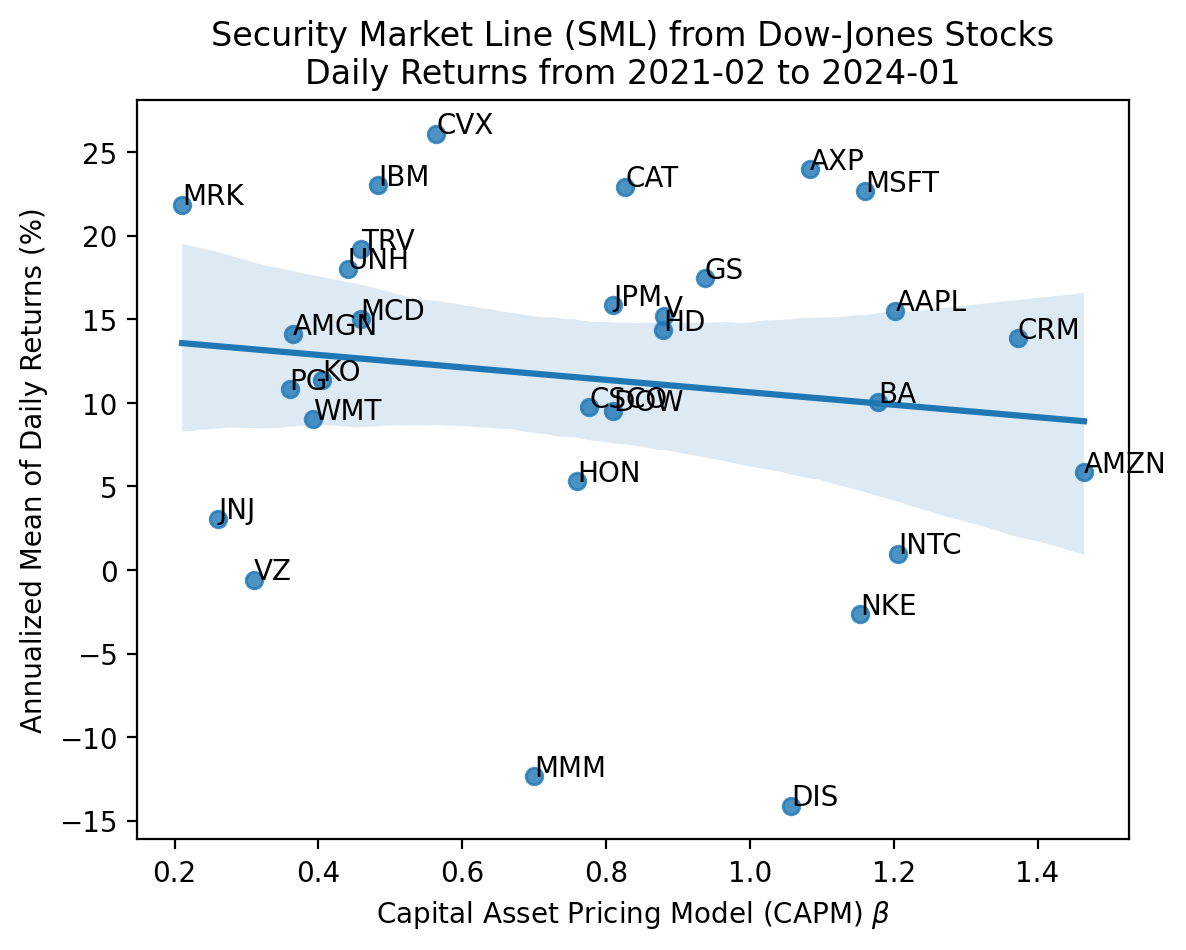

In [18]:
sns.regplot(
    data=djia_sml,
    x='calc_beta',
    y='calc_ann_mean'
)

for t, (x, y) in djia_sml[['calc_beta', 'calc_ann_mean']].iterrows():
    plt.annotate(text=t, xy=(x, y))
    
plt.ylabel('Annualized Mean of Daily Returns (%)')
plt.xlabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
plt.title(
    'Security Market Line (SML) from Dow-Jones Stocks\n' +
    'Daily Returns from 2021-02 to 2024-01'
)
plt.show()

For single stocks the SML falls apart!

1. The slope is negative and we would fail to reject it is flat
2. The intercept is above the risk-free rate
3. Many stocks plot outside the 95% confidence interval

In [19]:
djia_sml.corr().loc['calc_ann_mean', 'calc_beta']**2

0.0178

In [20]:
smf.ols(formula='calc_ann_mean ~ calc_beta', data=djia_sml).fit().rsquared

0.0178

### Plot the SML for the five portfolios formed on beta

Download data for portfolios formed on $\beta$ (`Portfolios_Formed_on_BETA`) from Ken French.
For the value-weighted portfolios, plot realized returns versus $\beta$.
These data should elements `[2]` and `[6]`, respectively.

In [21]:
ff_beta = pdr.DataReader(
    name='Portfolios_Formed_on_BETA',
    data_source='famafrench',
    start='1900'
)

print(ff_beta['DESCR'])

Portfolios Formed on BETA
-------------------------

This file was created by CMPT_BETA_RETS using the 202402 CRSP database. It contains value- and equal-weighted returns for portfolios formed on BETA. The portfolios are constructed at the end of June. Beta is estimated using monthly returns for the past 60 months (requiring at least 24 months with non-missing returns). Beta is estimated using the Scholes-Williams method. Annual returns are from January to December. Missing data are indicated by -99.99 or -999. The break points include utilities and include financials. The portfolios include utilities and include financials. Copyright 2024 Kenneth R. French

  0 : Value Weighted Returns -- Monthly (728 rows x 15 cols)
  1 : Equal Weighted Returns -- Monthly (728 rows x 15 cols)
  2 : Value Weighted Returns -- Annual from January to December (60 rows x 15 cols)
  3 : Equal Weighted Returns -- Annual from January to December (60 rows x 15 cols)
  4 : Number of Firms in Portfolios (728 ro

C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2406176535.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_beta = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2406176535.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_beta = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2406176535.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_beta = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2406176535.py:1: FutureWarning: The argument 'date_parse

In [22]:
ff_beta[2].tail()

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,,,,,,
2019,27.1700,29.7200,30.1300,37.7300,31.6700,27.8100,26.5400,28.8400,30.7600,30.0200,30.2900,33.0000,41.3000,28.7000,41.1800
2020,5.2800,12.3500,45.0300,41.5800,45.3000,2.9800,7.1300,12.4400,12.6900,38.0200,45.4700,13.9200,61.3100,23.5400,87.7700
2021,18.5600,28.8500,13.8500,48.5000,26.7600,18.1400,19.3500,26.8400,31.5400,20.1300,9.4100,54.1100,29.8300,40.4500,-2.0900
2022,-7.2500,-20.8600,-14.8000,-24.5900,-39.7300,-0.6100,-10.9100,-9.2800,-29.0900,-8.6400,-21.0600,-24.3400,-20.7500,-29.0300,-50.7600
2023,2.3000,27.9500,26.2600,44.3900,74.7900,3.8800,0.9900,14.1500,36.4700,28.8700,24.4100,41.0000,46.7500,85.9800,59.7000


In [23]:
ff_beta[6].tail()

,Lo 20,Qnt 2,Qnt 3,Qnt 4,Hi 20,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10
Date,,,,,,,,,,,,,,,
2019,0.2410,0.7710,1.1210,1.5020,2.2040,-0.0220,0.4350,0.6920,0.8520,1.0570,1.1920,1.3870,1.5870,1.8800,2.8550
2020,0.4320,0.9340,1.3400,1.6880,2.4090,0.2190,0.6040,0.8550,1.0360,1.2250,1.4090,1.5950,1.7960,2.1030,2.8770
2021,0.4600,0.8940,1.2690,1.6290,2.4640,0.1880,0.6030,0.8120,0.9850,1.1850,1.3520,1.5750,1.7970,2.2080,3.0420
2022,0.3740,0.8670,1.1530,1.5230,2.2120,0.2240,0.5020,0.7560,0.9260,1.0650,1.2230,1.3900,1.6010,1.9220,2.5190
2023,0.3950,0.8710,1.1630,1.5190,2.1440,0.2260,0.5320,0.7710,0.9380,1.1010,1.2400,1.4040,1.5700,1.9460,2.4110


We will combine the annual value-weighted returns data in `ff_beta[2]` with the value-weighted beta data in `ff_beta[6]` into one data frame `ff_beta_sml`.
We can easily use the `.join()` method if we first use the `stack()` method to convert the returns and beta data frames into long data frames.

In [24]:
ff_beta_sml = (
    ff_beta[2].iloc[:, :5] # annual value-weighted returns on quintile portfolios
    .stack() # convert to long data frame with one column of returns
    .to_frame('Return')
    .join(
        ff_beta[6].iloc[:, :5] # value-weighted betas from previous year on quintile portfolios
        .stack() # convert to long data frame with one column of betas
        .to_frame('Beta')
    )
    .rename_axis(
        index=['Data', 'Portfolio'],
        columns='Variable'
    )
)

ff_beta_sml.tail()

Variable        Return   Beta
Data Portfolio               
2023 Lo 20      2.3000 0.3950
     Qnt 2     27.9500 0.8710
     Qnt 3     26.2600 1.1630
     Qnt 4     44.3900 1.5190
     Hi 20     74.7900 2.1440

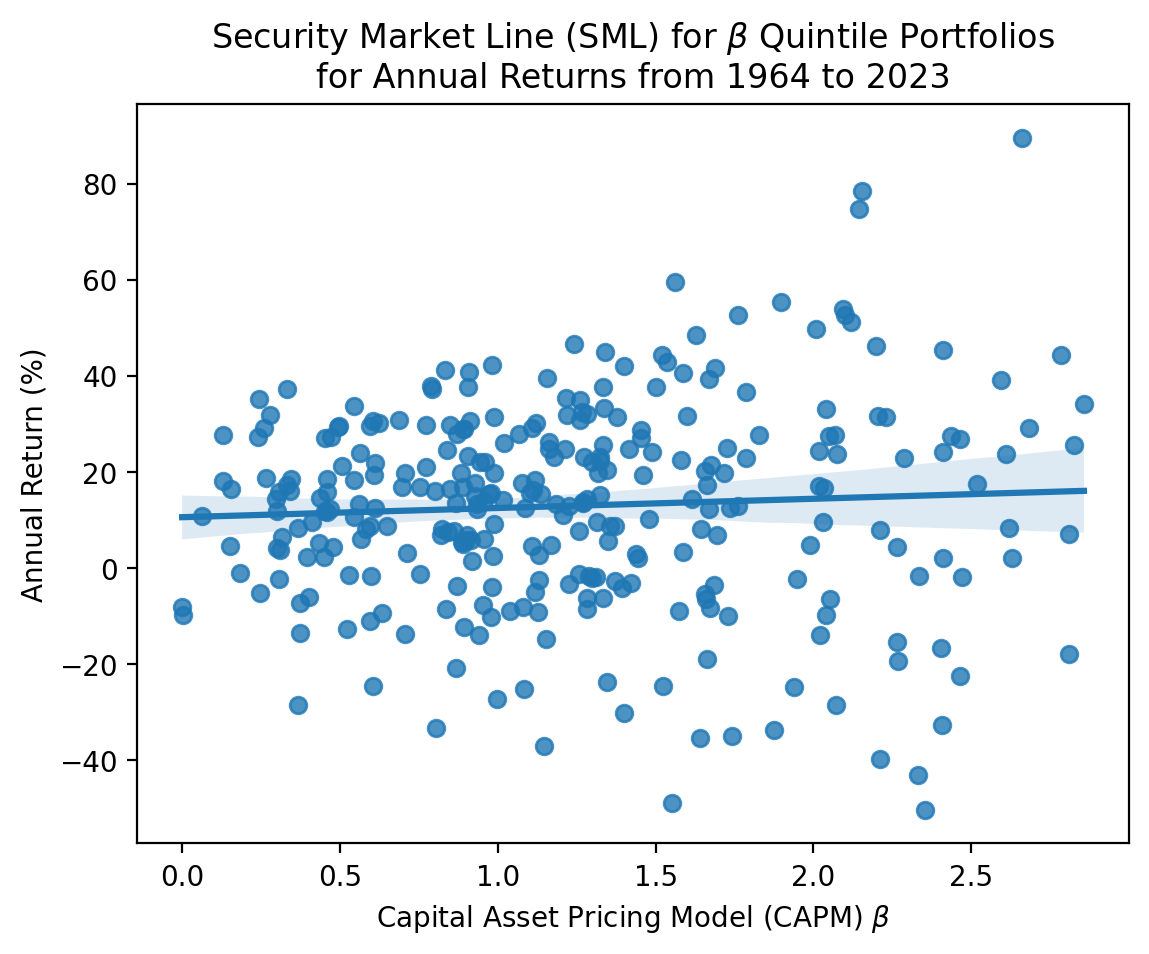

In [25]:
start = ff_beta_sml.index.get_level_values(0).year[0]
stop = ff_beta_sml.index.get_level_values(0).year[-1]

sns.regplot(
    data=ff_beta_sml,
    x='Beta',
    y='Return'
)

plt.ylabel('Annual Return (%)')
plt.xlabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
plt.title(
    r'Security Market Line (SML) for $\beta$ Quintile Portfolios' +
    f'\nfor Annual Returns from {start} to {stop}'
)
plt.show()

### Estimate the CAPM $\beta$s on several levered and inverse exchange traded funds (ETFs)

Try the following ETFs:

1. SPY
1. UPRO
1. SPXU

Can you determine what these products do from the data alone?
Estimate $\beta$s and plot cumulative returns.
You may want to pick short periods of time with large market swings.

In [26]:
etf_2 = (
    yf.download(tickers='SPY UPRO SPXU')
    .rename_axis(columns=['Variable', 'Ticker'])
    ['Adj Close']
    .iloc[:-1]
    .pct_change()
    .mul(100)
    .dropna()
)

[*********************100%%**********************]  3 of 3 completed


In [27]:
etf_2.apply(calc_beta).rename(r'$\beta$')

Ticker
SPXU   -2.8635
SPY     0.9582
UPRO    2.8790
Name: $\beta$, dtype: float64

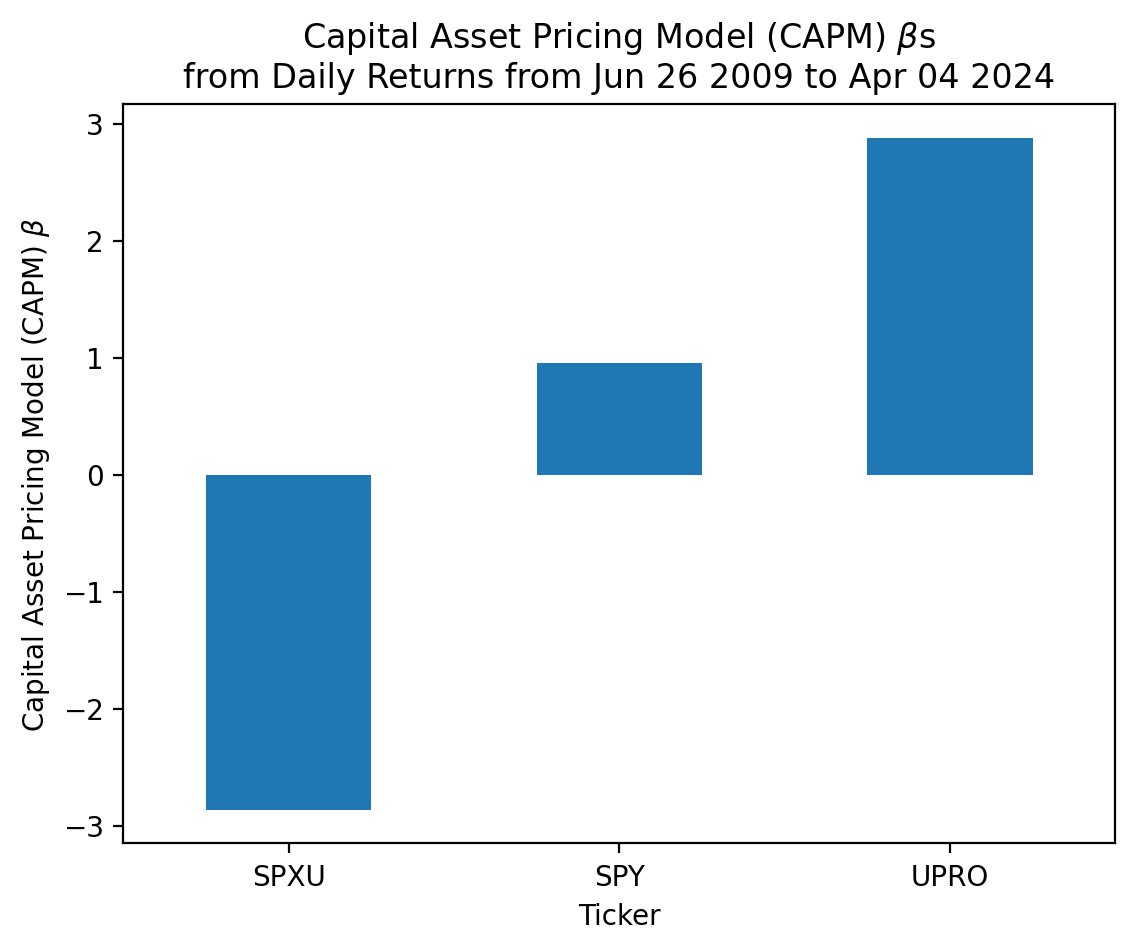

In [28]:
start = etf_2.index[0]
stop = etf_2.index[-1]

etf_2.apply(calc_beta).plot(kind='bar')
plt.xticks(rotation=0)
plt.ylabel(r'Capital Asset Pricing Model (CAPM) $\beta$')
plt.title(
    r'Capital Asset Pricing Model (CAPM) $\beta$s' + 
    f'\nfrom Daily Returns from {start:%b %d %Y} to {stop:%b %d %Y}'
)
plt.show()

### Explore the size factor

First, we need data for portfolio and factor returns.

In [29]:
ff_me = pdr.DataReader(
    name='Portfolios_Formed_on_ME',
    data_source='famafrench',
    start='1900'
)

print(ff_me['DESCR'])

C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\948145699.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_me = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\948145699.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_me = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\948145699.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_me = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\948145699.py:1: FutureWarning: The argument 'date_parser' is depr

Portfolios Formed on ME
-----------------------

This file was created by CMPT_ME_RETS using the 202402 CRSP database. It contains value- and equal-weighted returns for size portfolios. Each record contains returns for: Negative (not used) 30% 40% 30%   5 Quintiles  10 Deciles The portfolios are constructed at the end of Jun. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2024 Kenneth R. French

  0 : Value Weight Returns -- Monthly (1172 rows x 19 cols)
  1 : Equal Weight Returns -- Monthly (1172 rows x 19 cols)
  2 : Value Weight Returns -- Annual from January to December (97 rows x 19 cols)
  3 : Equal Weight Returns -- Annual from January to December (97 rows x 19 cols)
  4 : Number of Firms in Portfolios (1172 rows x 19 cols)
  5 : Average Firm Size (1172 rows x 19 cols)


In [30]:
ff_m = pdr.DataReader(
    name='F-F_Research_Data_Factors',
    data_source='famafrench',
    start='1900'
)

print(ff_m['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202402 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2024 Kenneth R. French

  0 : (1172 rows x 4 cols)
  1 : Annual Factors: January-December (97 rows x 4 cols)


C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\1667574714.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_m = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\1667574714.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_m = pdr.DataReader(


In [31]:
df_me = (
    ff_me[1]
    .iloc[:, -10:]
    .join(ff_m[0])
)

df_me.tail()

,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,
2023-10,-9.3900,-8.4100,-7.9700,-7.5300,-6.4900,-5.5100,-6.4000,-6.3600,-4.6000,-2.2600,-3.1900,-3.8700,0.1900,0.4700
2023-11,6.3000,9.0500,9.5800,9.6400,11.8700,9.6700,9.8400,9.6400,9.9900,9.2700,8.8400,-0.0200,1.6400,0.4400
2023-12,10.8700,17.2700,14.4800,14.2400,13.1200,12.0000,9.1600,9.6500,7.0000,5.5400,4.8700,6.3400,4.9300,0.4300
2024-01,-2.8200,-5.4600,-5.8600,-4.9400,-5.0700,-3.1900,-2.3800,-1.2600,-1.7100,1.5900,0.7100,-5.0900,-2.3800,0.4700
2024-02,5.5400,6.7100,4.8000,8.1900,3.4200,4.4400,6.3100,4.5400,5.7900,3.7100,5.0600,-0.2400,-3.4800,0.4200


#### Estimate $\alpha$s for the ten portfolios formed on size

Academics started researching size-based portfolios in the early 1980s, so you may want to focus on the pre-1980 sample.

In [32]:
mod = smf.ols(
    formula='I(Q("Lo 10") - RF) ~ Q("Mkt-RF")',
    data=df_me.loc[:'1980']
)
fit = mod.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     I(Q("Lo 10") - RF)   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     767.6
Date:                Fri, 05 Apr 2024   Prob (F-statistic):          2.92e-112
Time:                        17:46:25   Log-Likelihood:                -2343.5
No. Observations:                 654   AIC:                             4691.
Df Residuals:                     652   BIC:                             4700.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.9161      0.343      2.669      0.008       0.242       1.590
Q("Mkt-RF")     1.5976      0.058     27.706      0.000       1.484       1.711
==============================================================================
Omnibus:                      626.765   Durbin-Watson:                   1.970
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28924.644
Skew:                           4.226   Prob(JB):                         0.00
Kurtosis:                      34.464   Cond. No.                         5.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, we can use list comprehensions to quickly estimate all ten $\alpha$s.

In [33]:
ports = df_me.columns.to_list()[:10]

In [34]:
mods = [
    smf.ols(formula=f'I(Q("{p}")-RF) ~ Q("Mkt-RF")', data=df_me.loc['1994':])
    for
    p in ports
]
fits = [m.fit() for m in mods]

In [35]:
params = (
    pd.concat([f.params for f in fits], axis=1, keys=ports, names='Portolio')
    .transpose()
)

In [36]:
bses = (
    pd.concat([f.bse for f in fits], axis=1, keys=ports, names='Portfolio')
    .transpose()
)

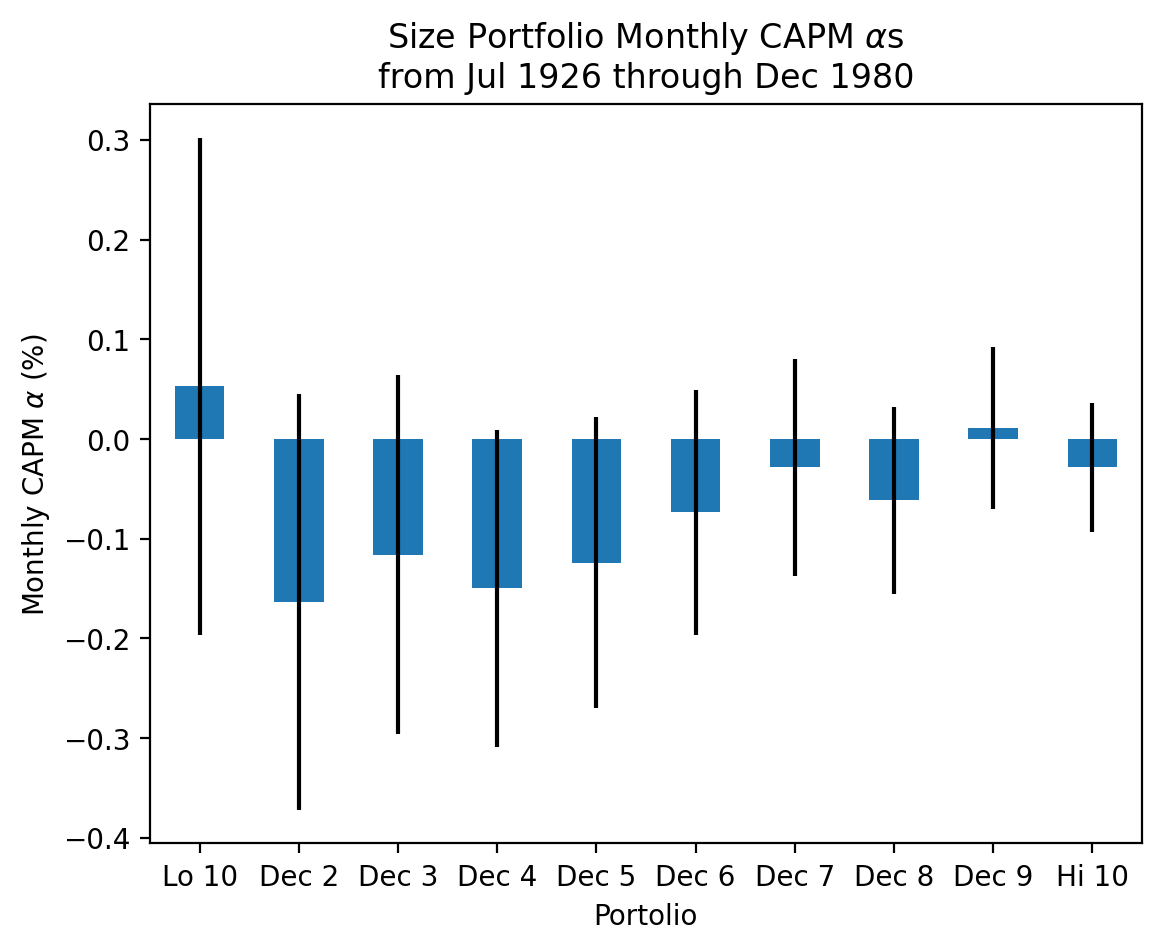

In [37]:
start = df_me.loc[:'1980'].index[0].to_timestamp()
stop = df_me.loc[:'1980'].index[-1].to_timestamp()

params['Intercept'].plot(kind='bar', yerr=bses['Intercept'])

plt.ylabel(r'Monthly CAPM $\alpha$ (%)')
plt.xticks(rotation=0)
plt.title(
    r'Size Portfolio Monthly CAPM $\alpha$s' +
    '\n' +
    f'from {start:%b %Y} through {stop:%b %Y}'
)
plt.show()

#### Are the returns on these ten portfolios formed on size concentrated in a specific month?

In [38]:
df_me_2 = (
    ff_me[0]
    .iloc[:, -10:]
    .stack()
    .rename_axis(index=['Date', 'Portfolio'])
    .to_frame('Return')
    .reset_index()
    .assign(Month=lambda x: np.where(x['Date'].dt.month==1, 'January', 'Not January'))
)

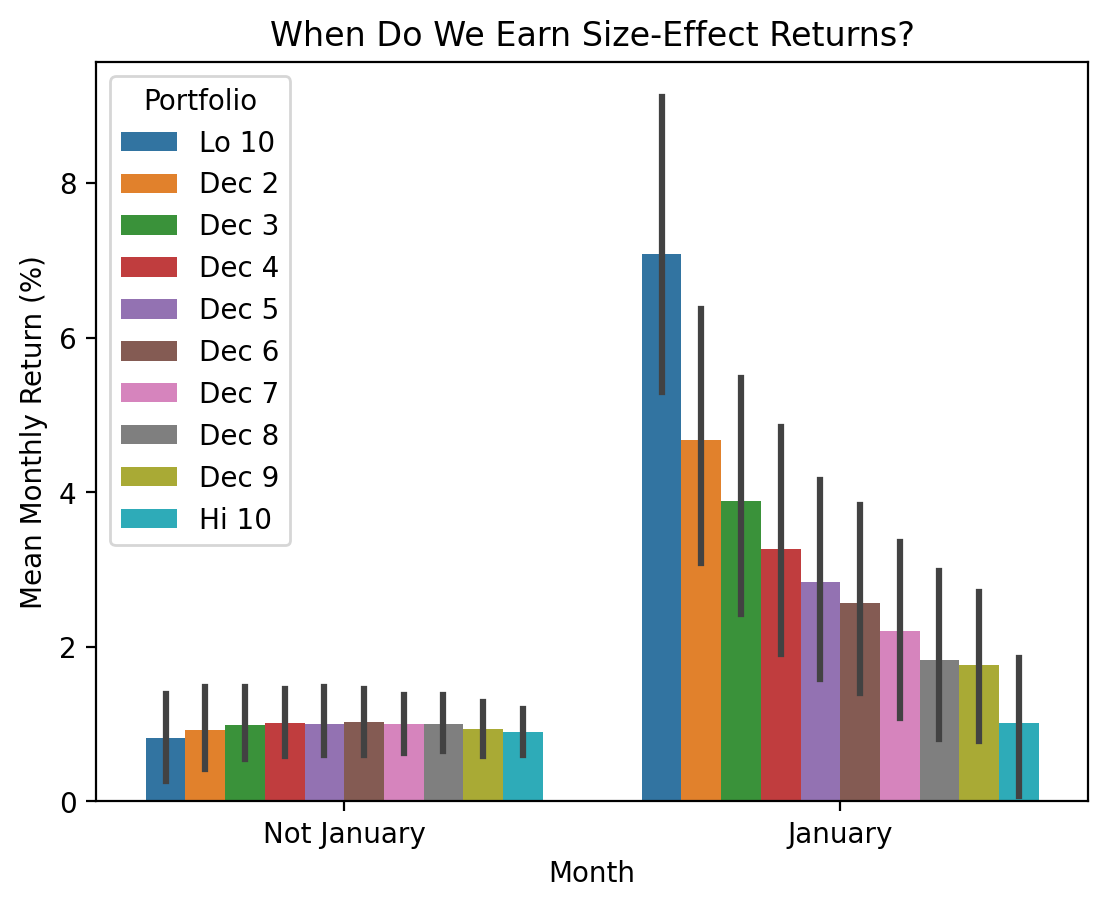

In [39]:
sns.barplot(
    data=df_me_2,
    x='Month',
    y='Return',
    hue='Portfolio'
)

plt.ylabel('Mean Monthly Return (%)')
plt.title('When Do We Earn Size-Effect Returns?')
plt.show()

#### Compare the size factor to the market factor

You may want to consider mean excess returns by decade.
The market and size excess returns are factors `Mkt-RF` and `SMB` in the Fama-French factors data.

In [40]:
df_me_3 = (
    ff_m[0]
    [['Mkt-RF', 'SMB']]
    .stack()
    .rename_axis(index=['Date', 'Factor'])
    .to_frame('Return')
    .reset_index()
    .assign(Decade=lambda x: (x['Date'].dt.year // 10 ) * 10)
)

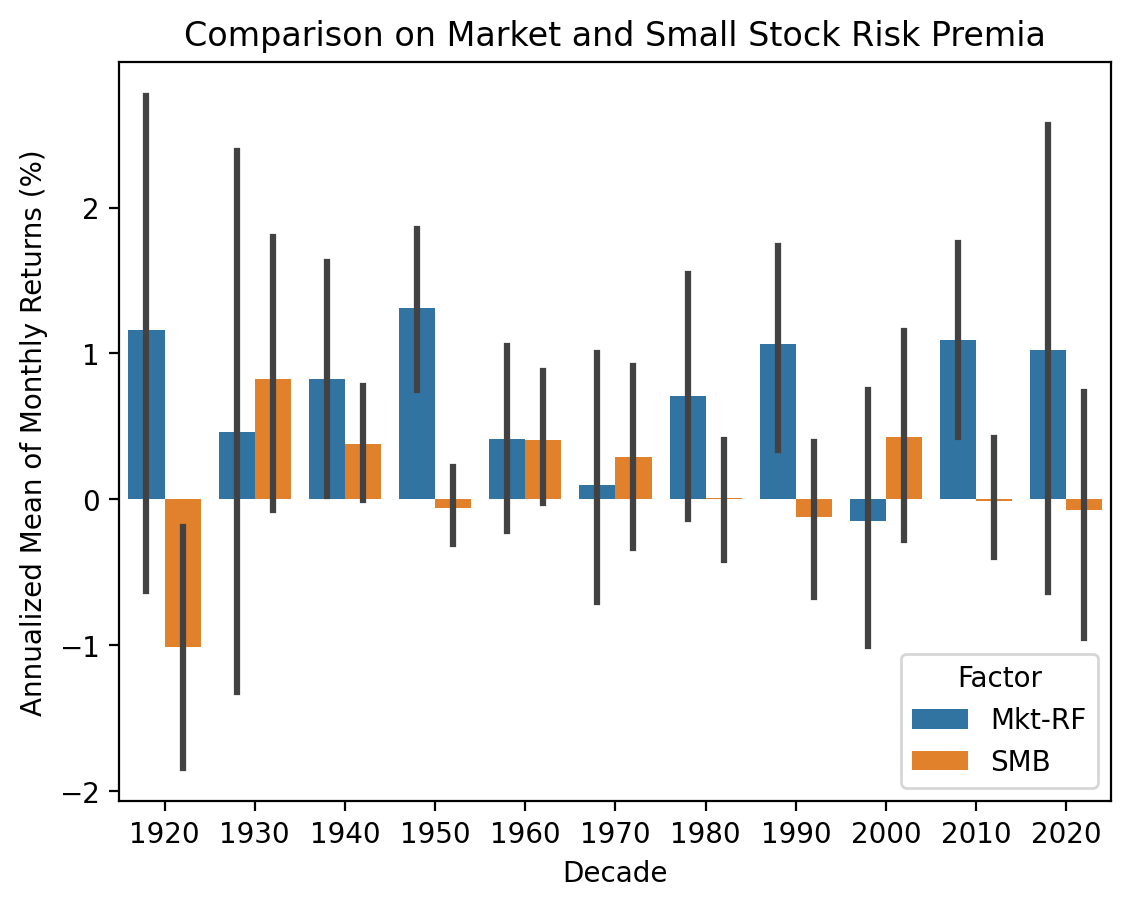

In [41]:
sns.barplot(
    data=df_me_3,
    x='Decade',
    y='Return',
    hue='Factor'
)

plt.ylabel('Annualized Mean of Monthly Returns (%)')
plt.title('Comparison on Market and Small Stock Risk Premia')
plt.show()

SMB rarely generates outsize returns later in the sample.

### Repeat the exercises above with the value factor

In [42]:
ff_be_me = pdr.DataReader(
    name='Portfolios_Formed_on_BE-ME',
    data_source='famafrench',
    start='1900'
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\1841624243.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_be_me = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\1841624243.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_be_me = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\1841624243.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_be_me = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\1841624243.py:1: FutureWarning: The argument 'date_pa

In [43]:
print(ff_me['DESCR'])

Portfolios Formed on ME
-----------------------

This file was created by CMPT_ME_RETS using the 202402 CRSP database. It contains value- and equal-weighted returns for size portfolios. Each record contains returns for: Negative (not used) 30% 40% 30%   5 Quintiles  10 Deciles The portfolios are constructed at the end of Jun. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2024 Kenneth R. French

  0 : Value Weight Returns -- Monthly (1172 rows x 19 cols)
  1 : Equal Weight Returns -- Monthly (1172 rows x 19 cols)
  2 : Value Weight Returns -- Annual from January to December (97 rows x 19 cols)
  3 : Equal Weight Returns -- Annual from January to December (97 rows x 19 cols)
  4 : Number of Firms in Portfolios (1172 rows x 19 cols)
  5 : Average Firm Size (1172 rows x 19 cols)


In [44]:
df_be_me = (
    ff_be_me[1]
    .iloc[:, -10:]
    .join(ff_m[0])
)

df_be_me.tail()

,Lo 10,Dec 2,Dec 3,Dec 4,Dec 5,Dec 6,Dec 7,Dec 8,Dec 9,Hi 10,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,
2023-10,-7.6200,-6.5300,-8.4300,-7.7500,-7.0200,-7.0800,-6.1800,-7.0600,-7.6800,-8.4300,-3.1900,-3.8700,0.1900,0.4700
2023-11,9.8800,9.8900,8.5700,7.1800,11.5300,13.6400,8.7100,10.5800,6.4300,6.6500,8.8400,-0.0200,1.6400,0.4400
2023-12,9.8700,9.2100,15.0800,11.0000,9.7200,11.9100,14.2700,14.1400,13.9600,13.2000,4.8700,6.3400,4.9300,0.4300
2024-01,-4.0000,-1.3500,-3.4800,-3.2100,-4.5000,-3.5100,-3.3800,-4.4200,-3.6400,-0.4200,0.7100,-5.0900,-2.3800,0.4700
2024-02,6.1900,7.6000,7.2500,5.2900,7.5200,7.6200,3.3800,3.3400,1.7400,7.2900,5.0600,-0.2400,-3.4800,0.4200


In [45]:
ports = df_be_me.columns.to_list()[:10]

In [46]:
mods = [
    smf.ols(formula=f'I(Q("{p}") - RF) ~ Q("Mkt-RF")', data=df_be_me)
    for
    p in ports
]

In [47]:
fits = [m.fit() for m in mods]

In [48]:
params = (
    pd.concat([f.params for f in fits], axis=1, keys=ports, names='Portolio')
    .transpose()
)

In [49]:
bses = (
    pd.concat([f.bse for f in fits], axis=1, keys=ports, names='Portfolio')
    .transpose()
)

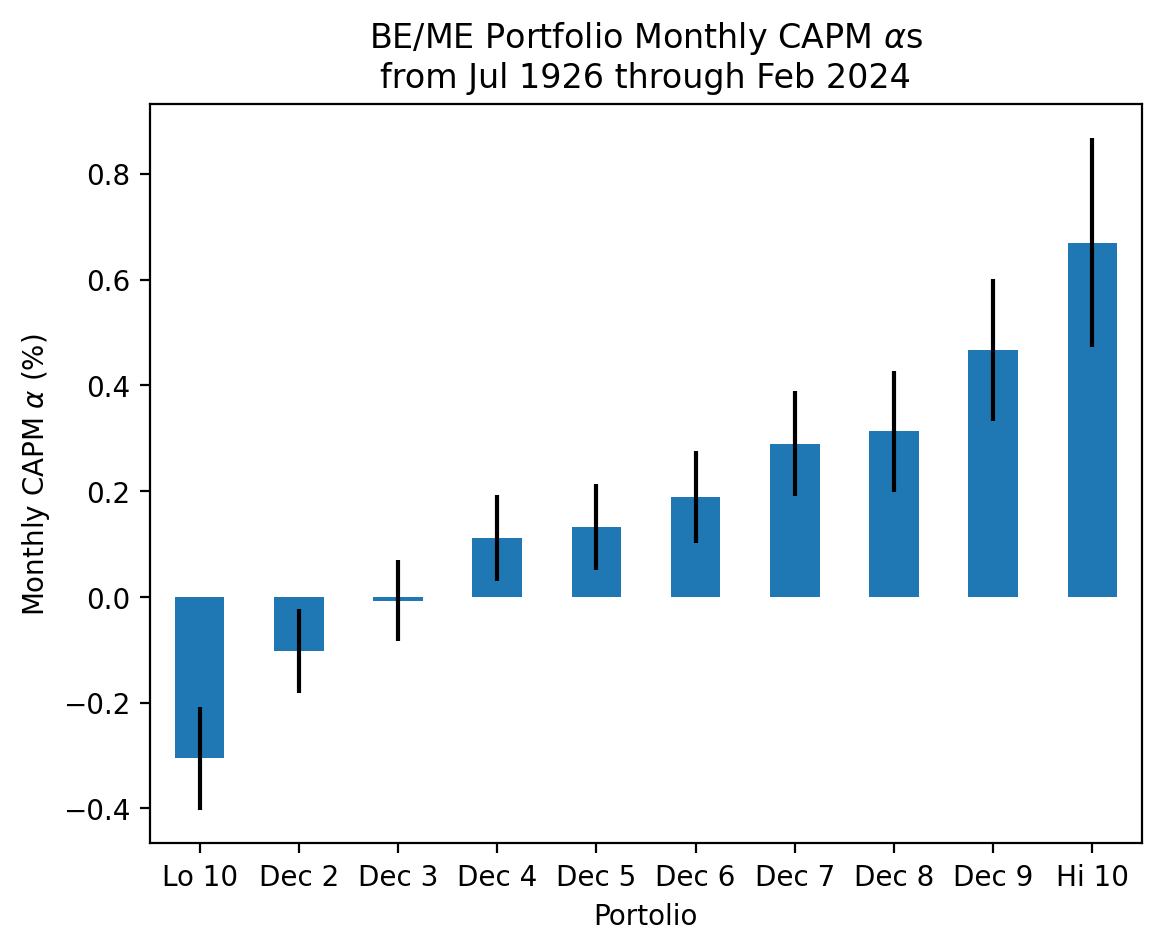

In [50]:
start = df_be_me.index[0].to_timestamp()
stop = df_be_me.index[-1].to_timestamp()

params['Intercept'].plot(kind='bar', yerr=bses['Intercept'])

plt.ylabel(r'Monthly CAPM $\alpha$ (%)')
plt.xticks(rotation=0)
plt.title(
    r'BE/ME Portfolio Monthly CAPM $\alpha$s' +
    '\n' +
    f'from {start:%b %Y} through {stop:%b %Y}'
)
plt.show()

In [51]:
df_be_me_3 = (
    ff_m[0]
    [['Mkt-RF', 'HML']]
    .stack()
    .rename_axis(index=['Date', 'Factor'])
    .to_frame('Return')
    .reset_index()
    .assign(Decade=lambda x: (x['Date'].dt.year // 10 ) * 10)
)

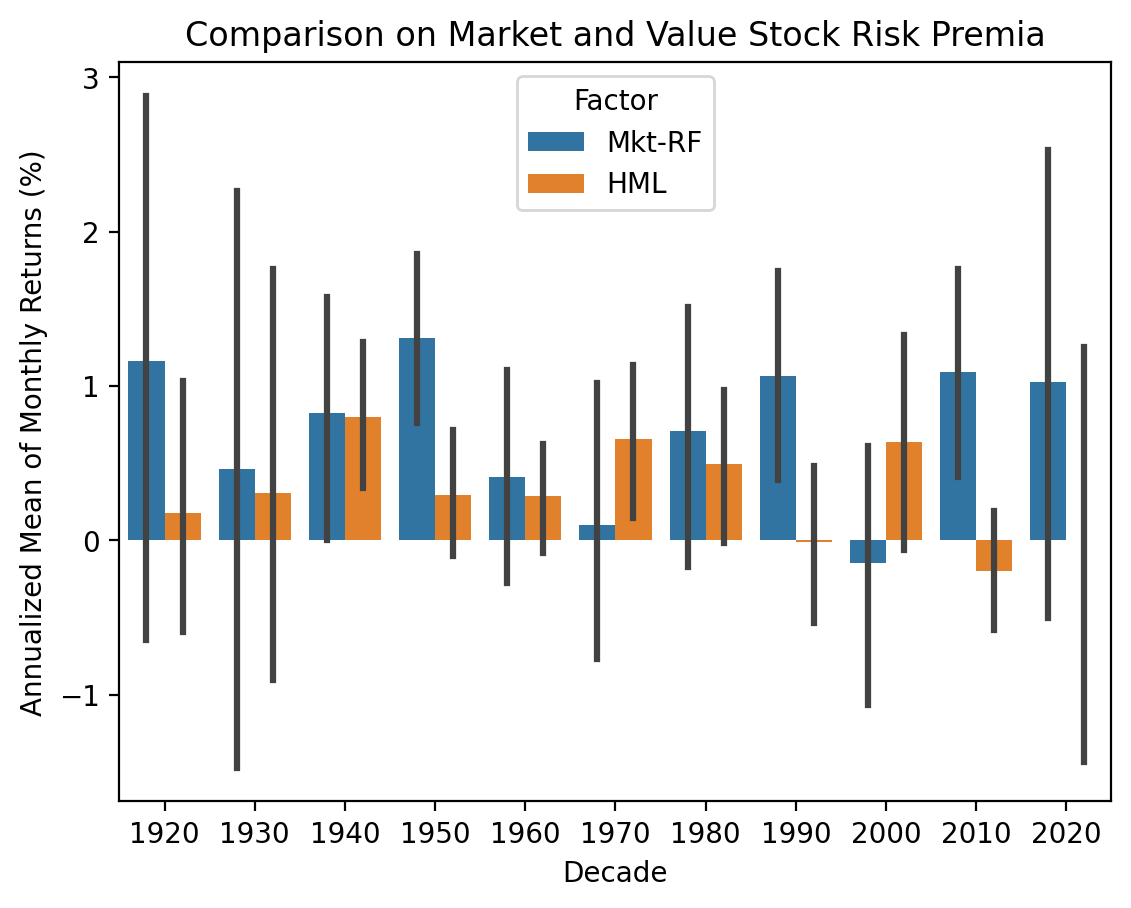

In [52]:
sns.barplot(
    data=df_be_me_3,
    x='Decade',
    y='Return',
    hue='Factor'
)

plt.ylabel('Annualized Mean of Monthly Returns (%)')
plt.title('Comparison on Market and Value Stock Risk Premia')
plt.show()

### Repeat the exercises above with the momentum factor

You may find it helpful to consider the worst months and years for the momentum factor.

In [53]:
ff_mom = pdr.DataReader(
    name='10_Portfolios_Prior_12_2',
    data_source='famafrench',
    start='1900'
)

C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2097656781.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_mom = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2097656781.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_mom = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2097656781.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_mom = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2097656781.py:1: FutureWarning: The argument 'date_parser' 

In [54]:
print(ff_mom['DESCR'])

10 Portfolios Prior 12 2
------------------------

This file was created by CMPT_PRIOR_RETS using the 202402 CRSP database. It contains value- and equal-weighted returns for 10 prior-return portfolios. The portfolios are constructed monthly. PRIOR_RET is from -12 to - 2. The annual returns are from January to December. Missing data are indicated by -99.99 or -999.

  0 : Average Value Weighted Returns -- Monthly (1166 rows x 10 cols)
  1 : Average Equal Weighted Returns -- Monthly (1166 rows x 10 cols)
  2 : Average Value Weighted Returns -- Annual (97 rows x 10 cols)
  3 : Average Equal Weighted Returns -- Annual (97 rows x 10 cols)
  4 : Number of Firms in Portfolios (1166 rows x 10 cols)
  5 : Average Firm Size (1166 rows x 10 cols)
  6 : Value-Weighted Average of Prior Returns (97 rows x 10 cols)


In [55]:
df_mom = (
    ff_mom[1]
    .iloc[:, -10:]
    .join(ff_m[0])
)

df_mom.tail()

,Lo PRIOR,PRIOR 2,PRIOR 3,PRIOR 4,PRIOR 5,PRIOR 6,PRIOR 7,PRIOR 8,PRIOR 9,Hi PRIOR,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,
2023-10,-11.8200,-8.0400,-5.4700,-4.4900,-5.6900,-4.9900,-4.7800,-6.1700,-6.4800,-8.7700,-3.1900,-3.8700,0.1900,0.4700
2023-11,7.8000,8.7100,7.1900,8.1500,7.7400,5.3800,8.0100,9.9700,10.4500,12.3300,8.8400,-0.0200,1.6400,0.4400
2023-12,14.9500,13.2800,14.0100,11.9000,10.5300,9.3300,6.5900,6.7600,8.4100,13.2100,4.8700,6.3400,4.9300,0.4300
2024-01,-6.8900,-5.0200,-3.9900,-2.2500,-2.3300,-2.4100,-0.9400,0.0400,-0.3900,-0.6600,0.7100,-5.0900,-2.3800,0.4700
2024-02,8.2200,3.9100,2.6200,2.4500,2.0900,3.8600,4.3500,5.4000,6.0200,10.5000,5.0600,-0.2400,-3.4800,0.4200


In [56]:
ports = df_mom.columns.to_list()[:10]

In [57]:
mods = [
    smf.ols(formula=f'I(Q("{p}") - RF) ~ Q("Mkt-RF")', data=df_mom.loc[:'1980'])
    for
    p in ports
]

In [58]:
fits = [m.fit() for m in mods]

In [59]:
params = (
    pd.concat([f.params for f in fits], axis=1, keys=ports, names='Portolio')
    .transpose()
)

In [60]:
bses = (
    pd.concat([f.bse for f in fits], axis=1, keys=ports, names='Portfolio')
    .transpose()
)

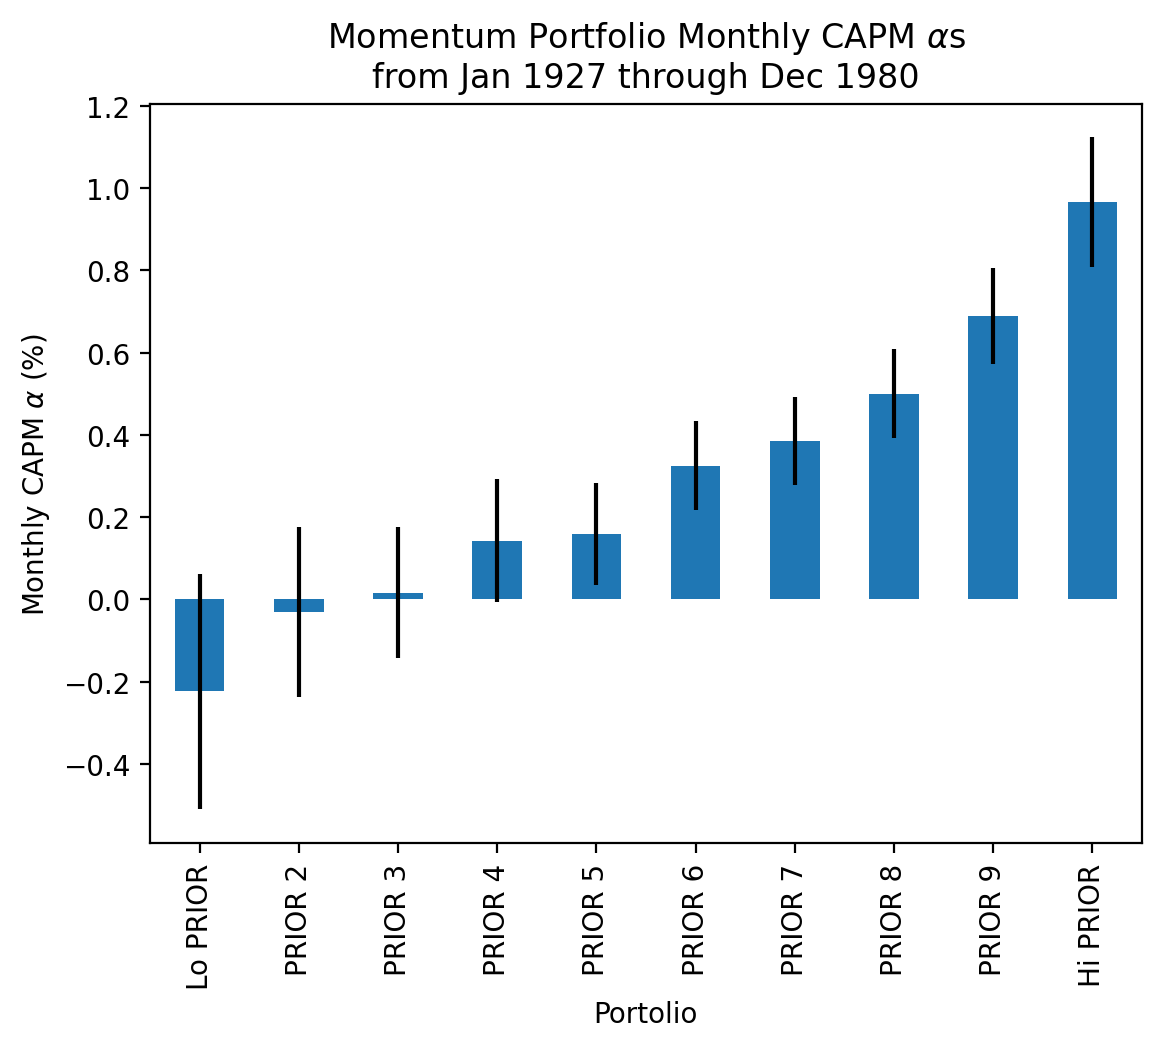

In [61]:
start = df_mom.loc[:'1980'].index[0].to_timestamp()
stop = df_mom.loc[:'1980'].index[-1].to_timestamp()

params['Intercept'].plot(kind='bar', yerr=bses['Intercept'])

plt.ylabel(r'Monthly CAPM $\alpha$ (%)')
plt.title(
    r'Momentum Portfolio Monthly CAPM $\alpha$s' +
    '\n' +
    f'from {start:%b %Y} through {stop:%b %Y}'
)
plt.show()

In [62]:
ff_mom = pdr.DataReader(
    name='F-F_Momentum_Factor',
    data_source='famafrench',
    start='1900'
)

ff_mom[0].columns = [c.strip() for c in ff_mom[0].columns]
ff_mom[0].tail()

C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\1313848978.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_mom = pdr.DataReader(
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\1313848978.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_mom = pdr.DataReader(


,Mom
Date,
2023-10,1.7300
2023-11,2.7500
2023-12,-5.5100
2024-01,5.1800
2024-02,4.9200


In [63]:
df_mom_3 = (
    ff_m[0].join(ff_mom[0])
    [['Mkt-RF', 'Mom']]
    .stack()
    .rename_axis(index=['Date', 'Factor'])
    .to_frame('Return')
    .reset_index()
    .assign(Decade=lambda x: (x['Date'].dt.year // 10 ) * 10)
)

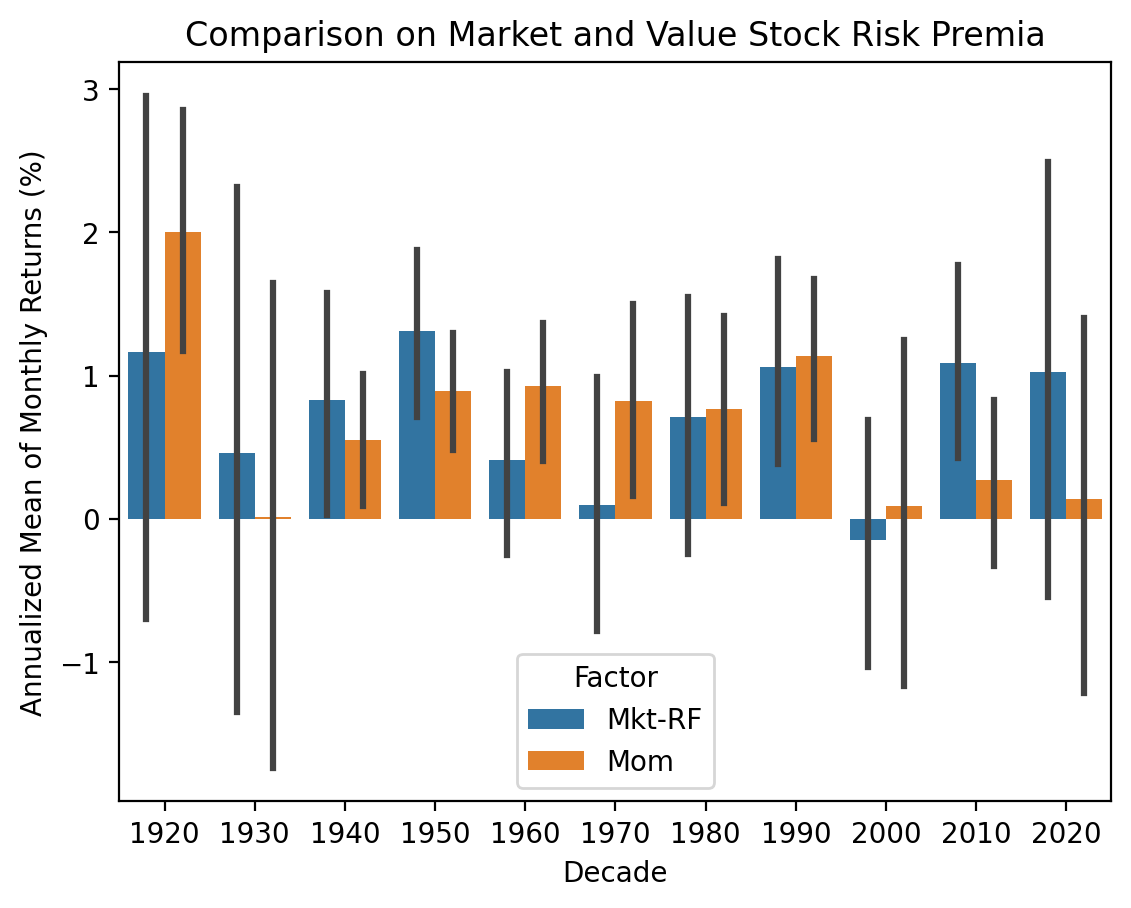

In [64]:
sns.barplot(
    data=df_mom_3,
    x='Decade',
    y='Return',
    hue='Factor'
)

plt.ylabel('Annualized Mean of Monthly Returns (%)')
plt.title('Comparison on Market and Value Stock Risk Premia')
plt.show()

### Plot the coefficient estimates from a rolling Fama-French three-factor model for Berkshire Hathaway

Use a three-year window with daily returns.
How has Buffett's $\alpha$ and $\beta$s changed over the past four decades?

In [65]:
brk = (
    yf.download(tickers='BRK-A')
    .iloc[:-1]
    .rename_axis(columns=['Variable'])
    .assign(r=lambda x: x['Adj Close'].pct_change().mul(100))
    .dropna()
    .join(
        pdr.DataReader(
            name='F-F_Research_Data_Factors_daily',
            data_source='famafrench',
            start='1900'
        )[0],
        how='inner'
    )
)

[*********************100%%**********************]  1 of 1 completed
C:\Users\r.herron\AppData\Local\Temp\ipykernel_20072\2930704642.py:8: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  pdr.DataReader(


In [66]:
from statsmodels.regression.rolling import RollingOLS

In [67]:
coefs = (
    RollingOLS.from_formula(
        formula='I(r-RF) ~ Q("Mkt-RF") + SMB + HML',
        data=brk,
        window=3*252
    )
    .fit()
    .params
    .rename_axis(columns='Coefficient')
    .rename(columns={'Q("Mkt-RF")': 'Mkt-RF'})
)

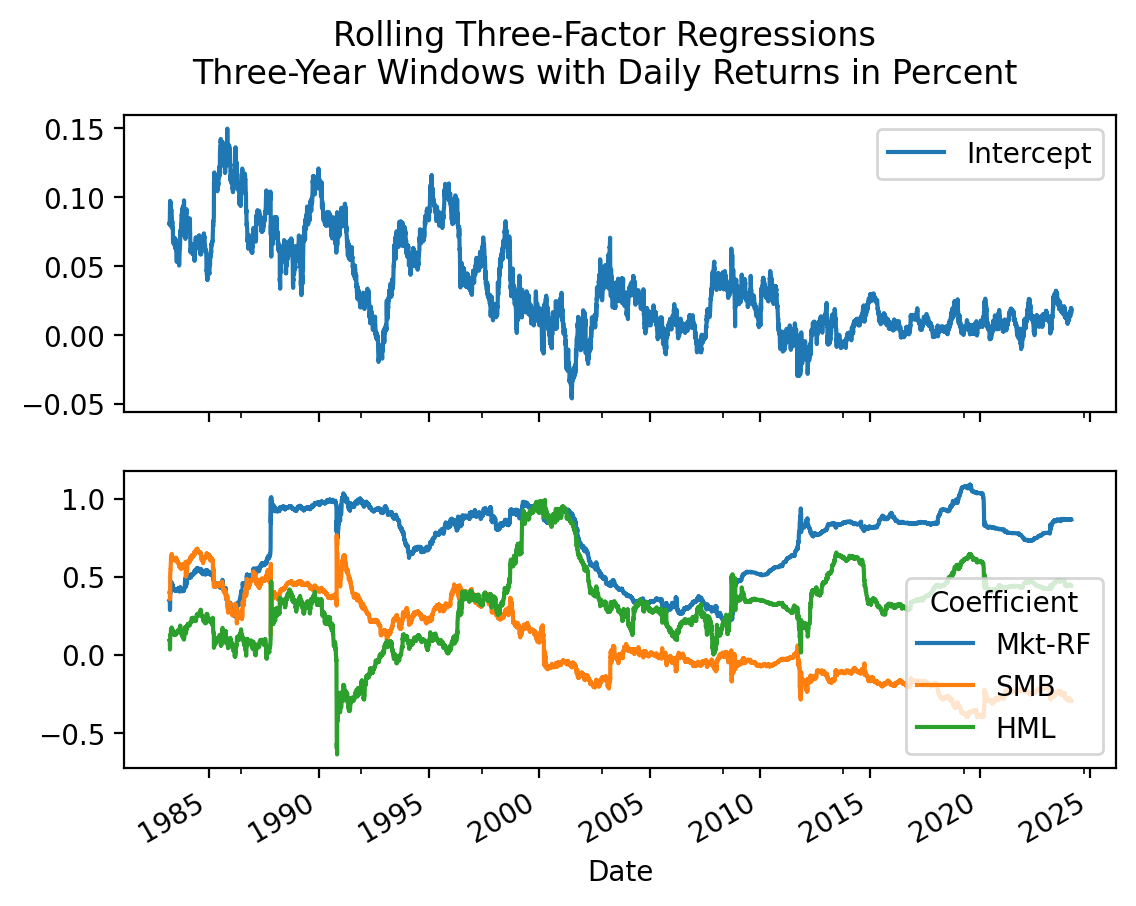

In [68]:
fig, ax = plt.subplots(2, 1, sharex=True)
coefs['Intercept'].plot(ax=ax[0], legend=True)
coefs.drop('Intercept', axis=1).plot(ax=ax[1])
plt.suptitle(
    'Rolling Three-Factor Regressions' +
    '\nThree-Year Windows with Daily Returns in Percent'
)
plt.show()

Buffett's $\alpha$ was large, but has declined to zero.
Also, his loading on SMB (size factor) has gone from positive to negative, indicating that he has moved from small stocks to large stocks as Berkshire Hathaway has grown.